# Synaptic Weights

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs/tutorial_toolbox/synaptic_weights.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs/tutorial_toolbox/synaptic_weights.ipynb)

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) 

In a brain model, synaptic weights, the strength of the connection between presynaptic and postsynaptic neurons, are crucial to the dynamics of the model. In this section, we will illutrate how to build synaptic weights in a synapse model.

In [28]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt

bp.math.set_platform('cpu')

In [29]:
bp.__version__

'2.4.0'

## Creating Static Weights

Some computational models focus on the network structure and its influence on network dynamics, thus not modeling neural plasticity for simplicity. In this condition, synaptic weights are fixed and do not change in simulation. They can be stored as a scalar, a matrix or a vector depending on the connection strength and density.

### 1. Storing weights with a scalar

If all synaptic weights are designed to be the same, the single weight value can be stored as a scalar in the synpase model to save memory space.

In [30]:
weight = 1.

The `weight` can be stored in a synapse model. When updating the synapse, this `weight` is assigned to all synapses by scalar multiplication. 

### 2. Storing weights with a matrix

**When the synaptic connection is dense and the synapses are assigned with different weights**, weights can be stored in a matrix $W$, where $W(i, j)$ refers to the weight of presynaptic neuron $i$ to postsynaptic neuron $j$.

BrainPy provides [`brainpy.initialize.Initializer`](../apis/auto/initialize.rst) (or `brainpy.init` for short) for weight initialization as a matrix. The tutorial of `brainpy.init.Initializer` is introduced later.

For example, a weight matrix can be constructed using `brainpy.init.Uniform`, which initializes weights with a random distribution:

In [31]:
pre_size = (4, 4)
post_size = (3, 3)

uniform_init = bp.init.Uniform(min_val=0., max_val=1.)
weights = uniform_init((np.prod(pre_size), np.prod(post_size)))
print('shape of weights: {}'.format(weights.shape))

shape of weights: (16, 9)


Then, the weights can be assigned to a group of connections with the same shape. For example, an all-to-all connection matrix can be obtained by `brainpy.conn.All2All()` whose tutorial is contained in [Synaptic Connections](synaptic_connections.ipynh):

In [32]:
conn = bp.conn.All2All()
conn(pre_size, post_size)
conn_mat = conn.requires('conn_mat')  # request the connection matrix

Therefore, `weights[i, j]` refers to the weight of connection `(i, j)`.

In [33]:
i, j = (2, 3)
print('whether (i, j) is connected: {}'.format(conn_mat[i, j]))
print('synaptic weights of (i, j): {}'.format(weights[i, j]))

whether (i, j) is connected: True
synaptic weights of (i, j): 0.4934258460998535


### 3. Storing weights with a vector

**When the synaptic connection is sparse, using a matrix to store synaptic weights is too wasteful.** Instead, the weights can be stored in a vector which has the same length as the synaptic connections.

<img src="../_static/synapses_and_weights.png" width="400 px">

Weights can be assigned to the corresponding synapses as long as the they are aligned with each other.

In [34]:
size = 5

conn = bp.conn.One2One()
conn(size, size)
pre_ids, post_ids = conn.requires('pre_ids', 'post_ids')

print('presynaptic neuron ids: {}'.format(pre_ids))
print('postsynaptic neuron ids: {}'.format(post_ids))
print('synapse ids: {}'.format(bm.arange(size)))

presynaptic neuron ids: [0 1 2 3 4]
postsynaptic neuron ids: [0 1 2 3 4]
synapse ids: [0 1 2 3 4]


The weight vector is aligned with the synapse vector, i.e. synapse ids :

In [35]:
weights = bm.random.uniform(0, 2, size)

for i in range(size):
    print('weight of synapse {}: {}'.format(i, weights[i]))

weight of synapse 0: 1.1880598068237305
weight of synapse 1: 0.224928617477417
weight of synapse 2: 0.0628659725189209
weight of synapse 3: 0.9465901851654053
weight of synapse 4: 0.6142964363098145


#### Conversion from a weight matrix to a weight vector
For users who would like to obtain the weight vector from the weight matrix, they can first build a connection according to the non-zero elements in the weight matrix and then slice the weight matrix according to the connection:

In [36]:
weight_mat = np.array([[1., 1.5, 0., 0.5], [0., 2.5, 0., 0.], [2., 0., 3, 0.]])
print('weight matrix: \n{}'.format(weight_mat))

conn = bp.conn.MatConn(weight_mat)
pre_ids, post_ids = conn.requires('pre_ids', 'post_ids')

weight_vec = weight_mat[pre_ids, post_ids]
print('weight_vector: \n{}'.format(weight_vec))

weight matrix: 
[[1.  1.5 0.  0.5]
 [0.  2.5 0.  0. ]
 [2.  0.  3.  0. ]]
weight_vector: 
[1.  1.5 0.5 2.5 2.  3. ]


```{note}
However, it is not recommended to use this function when the connection is sparse and of a large scale, because generating the weight matrix will take up too much space.
```

## Creating Dynamic Weights

Sometimes users may want to realize neural plasticity in a brain model, which requires the synaptic weights to change during simulation. In this condition, weights should be considered as **variables**, thus defined as `brainpy.math.Variable`. If it is packed in a synapse model, weight updating should be realized in the `update(_t, _dt)` function of the synapse model.

In [37]:
weights = bm.Variable(bm.ones(10))
weights

Variable(value=DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), dtype=float32)

## Built-in Weight Initializers

### Base Class: bp.init.Initializer

The base class of weight initializers are [`brainpy.initialize.Initializer`](../apis/auto/initialize.rst), which can be accessed by the shortcut `bp.init`. All initializers, built-in or costumized, should inherit the `Initializer` class. 

Weight initialization is implemented in the `__call__` function, so that it can be realized automatically when the initializer is called. The `__call__` function has a `shape` parameter that has different meanings in the following two superclasses and returns a **weight matrix**.

### Superclass 1: bp.init.InterLayerInitializer

The [`InterLayerInitializer`](../apis/auto/initialize.rst) is an abstract subclass of `Initializer`. Its subclasses initialize the weights between two fully connected layers. The `shape` parameter of the `__call__` function should be a 2-element tuple $(m, n)$, which refers to the number of presynaptic neurons $m$ and of postsynaptic neurons $n$. The output of the `__call__` function is a `bp.math.ndarray` with the shape of $(m, n)$, where the value at $(i, j)$ is the initialized weight of the presynaptic neuron $i$ to postsynpatic neuron $j$.

### Superclass 2: bp.init.IntraLayerInitializer

The [`IntraLayerInitializer`](../apis/auto/initialize.rst) is also an abstract subclass of `Initializer`. Its subclasses initialize the weights within a single layer. The `shape` parameter of the `__call__` function refers to the the structure of the neural population $(n_1, n_2, ..., n_d)$. The `__call__` function returns a 2-D `bp.math.ndarray` with the shape of $(\prod_{k=1}^d n_k, \prod_{k=1}^d n_k)$. In the 2-D array, the value at $(i, j)$ is the initialized weight of neuron $i$ to neuron $j$ of the flattened neural sequence.

### 1. Built-In Regular Initializers

Regular initializers all belong to `InterLayerInitializer` and initialize the connection weights between two layers with a regular pattern. There are `ZeroInit`, `OneInit`, and `Identity` initializers in built-in regular initializers. Here we show how to use the `OneInit` initializer. The remaining two classes are used in a similar way.

In [38]:
# visualization
def mat_visualize(matrix, cmap=plt.cm.get_cmap('coolwarm')):
    im = plt.matshow(matrix, cmap=cmap)
    plt.colorbar(mappable=im, shrink=0.8, aspect=15)
    plt.show()

In [39]:
# 'OneInit' initializes all the weights with the same value
shape = (5, 6)
one_init = bp.init.OneInit(value=2.5)
weights = one_init(shape)
print(weights)

Array(value=DeviceArray([[2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                         [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                         [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                         [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                         [2.5, 2.5, 2.5, 2.5, 2.5, 2.5]]),
      dtype=float32)


### 2. Built-In Random Initializers

Random initializers all belong to `InterLayerInitializer` and initialize the connection weights between two layers with a random distribution. There are `Normal`, `Uniform`, `Orthogonal` and other initializers in built-in regular initializers. Here we show how to use the `Normal` and `Uniform` initializers.

**bp.init.Normal**

This initializer initializes the weights with a normal distribution. The variance of the distribution changes according to the `scale` parameter. In the following example, 10 presynaptic neurons are fully connected to 20 postsynaptic neurons with random weight values:

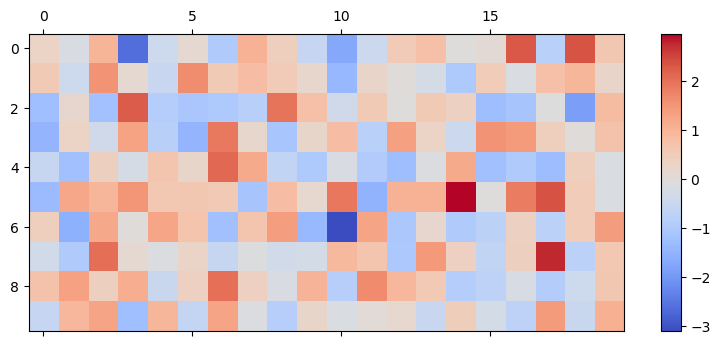

In [40]:
shape = (10, 20)
normal_init = bp.init.Normal(scale=1.0)
weights = normal_init(shape)
mat_visualize(weights)

**bp.init.Uniform**

This initializer resembles `brainpy.init.Normal` but initializes the weights with a uniform distribution.

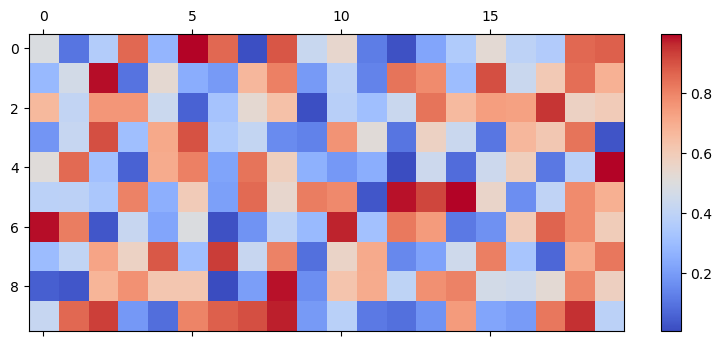

In [41]:
uniform_init = bp.init.Uniform(min_val=0., max_val=1.)
weights = uniform_init(shape)
mat_visualize(weights)

### 3. Built-In Decay Initializers

Decay initializers all belong to `IntraLayerInitializer` and initialize the connection weights within a layer with a decay function according to the neural distance. There are `GaussianDecay` and `DOGDecay` initializers in built-in decay initializers. Below are examples of how to use them.

**brainpy.training.initialize.GaussianDecay**

This initializer creates a Gaussian connectivity pattern within a population of neurons, where the weights decay with a gaussian function.
Specifically, for any pair of neurons $ (i, j) $, the weight is computed as

$$
w(i, j) = w_{max} \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2 }{2\sigma^2})
$$

where $ v_k^i $ is the $ i $-th neuron's encoded value (position) at dimension $ k $.

The example below is a neural population with the size of $ 5 \times 5 $. Note that this shape is the structure of the target neural population, not the size of presynaptic and postsynaptic neurons.

In [42]:
size = (5, 5)
gaussian_init = bp.init.GaussianDecay(sigma=2., max_w=10., include_self=True)
weights = gaussian_init(size)
print('shape of weights: {}'.format(weights.shape))

shape of weights: (25, 25)


Self-connections are created if `include_self=True`. The connection weights of neuron $i$ with others are stored in row $i$ of `weights`. For instance, the connection weights of neuron(1, 2) to other neurons are stored in `weights[7]` ($5 \times 1 +2 = 7$). After reshaping, the weights are:

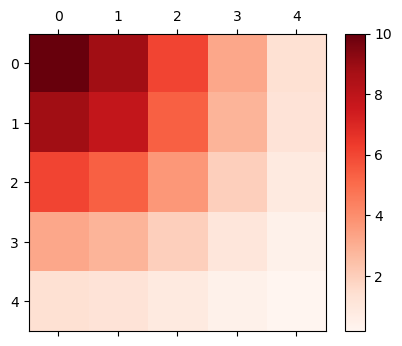

In [43]:
mat_visualize(weights[0].reshape(size), cmap=plt.cm.get_cmap('Reds'))

**brainpy.training.initialize.DOGDecay**

This initializer creates a Difference-Of-Gaussian (DOG) connectivity pattern within a population of neurons. Specifically, for the given pair of neurons $ (i, j) $, the weight between them is computed as

$$
w(i, j) = w_{max}^+ \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2}{2\sigma_+^2}) - w_{max}^- \cdot \exp(-\frac{\sum_{k=1}^n |v_k^i - v_k^j|^2}{2\sigma_-^2})
$$

where $ v_k^i $ is the $ i $-th neuron's encoded value (position) at dimension $ k $.

<center><img src="../_static/DOGDecay.png" width="300 px"></center>

The example below is a neural population with the size of $ 10 \times 12 $:

In [44]:
size = (10, 12)
dog_init = bp.init.DOGDecay(sigmas=(1., 3.), max_ws=(10., 5.), min_w=0.1, include_self=True)
weights = dog_init(size)
print('shape of weights: {}'.format(weights.shape))

shape of weights: (120, 120)


Weights smaller than `min_w` will not be created. `min_w` $ = 0.005 \times min( $ `max_ws` $ ) $ if it is not assigned with a value.
The organization of `weights` is similar to that in the `GaussianDecay` initializer. For instance, the connection weights of neuron (3, 4) to other neurons after reshaping are shown as below:

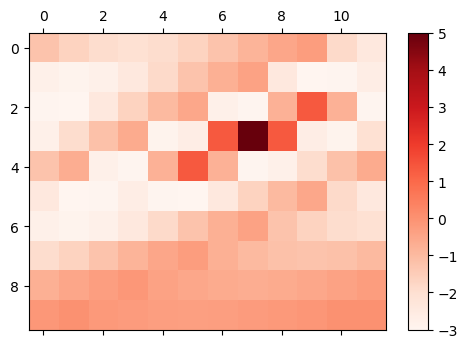

In [45]:
mat_visualize(weights[3*12+4].reshape(size), cmap=plt.cm.get_cmap('Reds'))

## Customizing your initializers

BrainPy also allows users to customize the weight initializers of their own. When customizing a initializer, users should follow the instructions below:
- Your initializer should inherit `brainpy.initialize.Initializer`.
- Override the `__call__` funtion, to which the `shape` parameter should be given.

Here is an example of creating an inter-layer initializer that initialize the weights as follows:

$$
w(i, j) = max(w_{max} - \sigma |v_i - v_j|, 0)
$$

In [46]:
class LinearDecay(bp.init.Initializer):
    def __init__(self, max_w, sigma=1.):
        self.max_w = max_w
        self.sigma = sigma
    
    def __call__(self, shape, dtype=None):
        mat = bp.math.zeros(shape, dtype=dtype)
        n_pre, n_post = shape
        seq = np.arange(n_pre)
        current_w = self.max_w
        
        for i in range(max(n_pre, n_post)):
            if current_w <= 0:
                break
            seq_plus = ((seq + i) >= 0) & ((seq + i) < n_post)
            seq_minus = ((seq - i) >= 0) & ((seq - i) < n_post)
            mat[seq[seq_plus], (seq + i)[seq_plus]] = current_w
            mat[seq[seq_minus], (seq - i)[seq_minus]] = current_w
            current_w -= self.sigma
        
        return mat

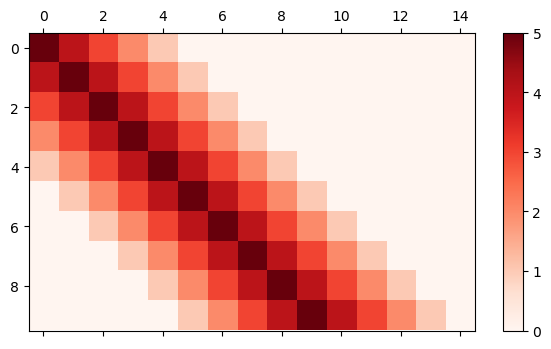

In [47]:
shape = (10, 15)
lin_init = LinearDecay(max_w=5, sigma=1.)
weights = lin_init(shape)
mat_visualize(weights, cmap=plt.cm.get_cmap('Reds'))

```{note}
Note that customized initializers, or ``brainpy.init.Initializer``, is not limited to returning a matrix. Although currently all the built-in initializers use matrix to store weights, they can also be designed to return a vector to store synaptic weights.
```